# Importing request

In [1]:
import requests
import json
from pprint import pprint
import pandas as pd
import random
import statsmodels.api as sm
import matplotlib.pyplot as plt
import numpy as np
from config import api_key
from config import api_id
from config import api_key2

# Creating random list for MSAs
Keith wrote the code to generate the random list from the top polluting MSAs

In [2]:
# The data to load
f = "../data/msa.csv"

# Count the lines
num_lines = sum(1 for l in open(f))

# Sample size - retrieving header and 5 MSA's
size = 10

# The row indices to skip - make sure 0 is not included to keep the header
skip_idx = random.sample(range(1, num_lines), num_lines - size)

# Read the data
msa = pd.read_csv(f, skiprows=skip_idx)

# Display the sample
msa


,MSA
0,"Birmingham-Hoover-Talladega, AL"
1,"Chicago-Naperville, IL-IN-WI"
2,"Cincinnati-Wilmington-Maysville, OH-KY-IN"
3,"Detroit-Warren-Ann Arbor, MI"
4,"Fresno-Madera-Hanford, CA"
5,"Indianapolis-Carmel-Muncie, IN"
6,"Los Angeles-Long Beach, CA"
7,"San Jose-San Francisco-Oakland, CA"
8,"Shreveport-Bossier City-Minden, LA"


# Striping Leading/Trailing Spaces for Merge

In [3]:
msa['MSA1']=msa['MSA'].str.strip()
msa.loc[msa['MSA1']=='Detroit-Warren-Ann Arbor, MI']

,MSA,MSA1
3,"Detroit-Warren-Ann Arbor, MI","Detroit-Warren-Ann Arbor, MI"


# Reading in MSA Crosswalk info for MSA codes

In [4]:
file = "../data/msa_crosswalk.csv"
crosswalk = pd.read_csv(file)
crosswalk1 = crosswalk[['CBSA Code','CSA Title']].sort_values('CSA Title',ascending = False).rename(columns = {'CSA Title':'MSA1'}).dropna().drop_duplicates()
crosswalk1

,CBSA Code,MSA1
1503,41400,"Youngstown-Warren, OH-PA"
1893,49660,"Youngstown-Warren, OH-PA"
1865,48700,"Williamsport-Lock Haven, PA"
974,30820,"Williamsport-Lock Haven, PA"
1860,48620,"Wichita-Arkansas City-Winfield, KS"
...,...,...
660,24100,"Albany-Schenectady, NY"
31,10580,"Albany-Schenectady, NY"
656,24020,"Albany-Schenectady, NY"
60,11220,"Albany-Schenectady, NY"


# Joining MSA Crosswalk to Top MSAs to get the CBSA Codes needed for API Pulls

In [5]:
msa_codes = pd.merge(crosswalk1,msa,
                how = 'inner',
                on = 'MSA1')

msa_codes.head()

,CBSA Code,MSA1,MSA
0,41860,"San Jose-San Francisco-Oakland, CA","San Jose-San Francisco-Oakland, CA"
1,46700,"San Jose-San Francisco-Oakland, CA","San Jose-San Francisco-Oakland, CA"
2,44700,"San Jose-San Francisco-Oakland, CA","San Jose-San Francisco-Oakland, CA"
3,34900,"San Jose-San Francisco-Oakland, CA","San Jose-San Francisco-Oakland, CA"
4,42220,"San Jose-San Francisco-Oakland, CA","San Jose-San Francisco-Oakland, CA"


# API Call - Pollution Part 1
using a for loop to loop through three years work of PM2.5 data

In [6]:
response_sample = []
start = ["20160101"]
end = ["20161231"]
codes = msa_codes['CBSA Code']


for index in range(len(start)):
    for each_msa in codes:
        url = f"https://aqs.epa.gov/data/api/sampleData/byCBSA?email={api_id}&key={api_key}&param=88101&bdate={start[index]}&edate={end[index]}&cbsa={each_msa}"
        response_sample.append(requests.get(url).json())

# Pulling Data and putting in list
There are two loops, the first loop is through the 33 different MSAs. Unfortunately the EPA does not always sample every 3 dyas like their website says. This leads to certain sampling sites having different lengths of samples. The second loop goes from 0 to the length of the number of samples they do have

In [7]:
time = []
date = []
cbsa_code = []
lat = []
lon = []
site = []
sample = []


for x in range(len(response_sample)):
    for y in range(0,response_sample[x]['Header'][0]['rows']):
        time.append(response_sample[x]['Data'][y]['time_local'])
        date.append(response_sample[x]['Data'][y]['date_local'])
        cbsa_code.append(response_sample[x]['Data'][y]['cbsa_code'])
        lat.append(response_sample[x]['Data'][y]['latitude'])
        lon.append(response_sample[x]['Data'][y]['longitude'])
        site.append(response_sample[x]['Data'][y]['site_number'])
        sample.append(response_sample[x]['Data'][y]['sample_measurement'])

        
columns = ['time','date','cbsa_code','lat','lon','site','sample']
df_sample = pd.DataFrame(data = list(zip(time,date,cbsa_code,lat,lon,site,sample)), columns = columns)
df_sample.head()

,time,date,cbsa_code,lat,lon,site,sample
0,00:00,2016-01-01,41860,37.482934,-122.20337,1001,54.0
1,01:00,2016-01-01,41860,37.482934,-122.20337,1001,16.0
2,02:00,2016-01-01,41860,37.482934,-122.20337,1001,20.0
3,03:00,2016-01-01,41860,37.482934,-122.20337,1001,4.0
4,04:00,2016-01-01,41860,37.482934,-122.20337,1001,4.0


# Converting date to DateTime
needed to group by month which is format that Oil Data is in

In [8]:
df_sample['date'] = pd.to_datetime(df_sample.date,format = '%Y-%m')
df_sample.head(1)

,time,date,cbsa_code,lat,lon,site,sample
0,00:00,2016-01-01,41860,37.482934,-122.20337,1001,54.0


In [9]:
df_sample['month_year'] = df_sample['date'].dt.strftime('%m-%Y')
df_sample.head(1)

,time,date,cbsa_code,lat,lon,site,sample,month_year
0,00:00,2016-01-01,41860,37.482934,-122.20337,1001,54.0,01-2016


checking number of distinct sites

In [10]:
df_sample= df_sample.astype({'sample': float})

# Grouping Hourly Data by day & Merging
PM2.5 data is organized by hour, but we need it on a daily level so it can map in with the AQI levels. First we do a groupby to get daily levels, then we need to remerge with the original data to get the categorical data back in (county, site, lat, lon)

In [11]:
df_sample1 = df_sample[['site','sample','month_year','cbsa_code']].groupby(['month_year','cbsa_code','site']).mean().reset_index().sort_values('month_year',ascending = False)
df_sample1.head()
len(df_sample1)
df_sample1

,month_year,cbsa_code,site,sample
1341,12-2016,46700,0004,12.510825
1285,12-2016,26900,0011,9.593324
1259,12-2016,17140,0006,8.638791
1260,12-2016,17140,0010,10.280000
1261,12-2016,17140,0014,11.460000
...,...,...,...,...
79,01-2016,37100,0009,3.860283
80,01-2016,37100,1004,8.823212
81,01-2016,37100,2002,6.343051
82,01-2016,37100,3001,6.975477


# Same process for PM2.5 now for AQI
AQI = Air Quality Index
This is not done every day but every 1 - 3 days depending on how the EPA decided to track it.

In [12]:
response_daily = []
start = ["20160101"]
end = ["20161231"]
codes = msa_codes['CBSA Code']

for index in range(len(start)):
    for each_msa in codes:
        url = f"https://aqs.epa.gov/data/api/dailyData/byCBSA?email={api_id}&key={api_key}&param=88101&bdate={start[index]}&edate={end[index]}&cbsa={each_msa}"
        response_daily.append(requests.get(url).json())

In [13]:
len(response_daily)

34

In [14]:
date = []
cbsa_code = []
lat = []
lon = []
site = []
aqi = []


for x in range(len(response_daily)):
    for y in range(0,response_daily[x]['Header'][0]['rows']):
        date.append(response_daily[x]['Data'][y]['date_local'])
        aqi.append(response_daily[x]['Data'][y]['aqi'])
        cbsa_code.append(response_daily[x]['Data'][y]['cbsa_code'])
        lat.append(response_daily[x]['Data'][y]['latitude'])
        lon.append(response_daily[x]['Data'][y]['longitude'])
        site.append(response_daily[x]['Data'][y]['site_number'])

        
columns = ['date','aqi','cbsa_code','lat','lon','site']
df_daily = pd.DataFrame(data = list(zip(date,aqi,cbsa_code,lat,lon,site)), columns = columns).drop_duplicates().dropna()
df_daily.head()

,date,aqi,cbsa_code,lat,lon,site
0,2016-12-31,28.0,41860,37.864767,-122.302741,0013
1,2016-12-30,59.0,41860,37.864767,-122.302741,0013
2,2016-12-29,62.0,41860,37.864767,-122.302741,0013
15,2016-12-28,33.0,41860,37.864767,-122.302741,0013
20,2016-12-27,30.0,41860,37.864767,-122.302741,0013


In [15]:
len(df_daily)

29609

In [16]:
df_daily['date'] = pd.to_datetime(df_daily.date,format = '%Y-%m')
df_daily.head(1)

,date,aqi,cbsa_code,lat,lon,site
0,2016-12-31,28.0,41860,37.864767,-122.302741,0013


In [17]:
df_daily['month_year'] = df_daily['date'].dt.strftime('%m-%Y')
df_daily.head(1)

,date,aqi,cbsa_code,lat,lon,site,month_year
0,2016-12-31,28.0,41860,37.864767,-122.302741,0013,12-2016


In [72]:
df_daily1 = df_daily[['site','aqi','month_year','cbsa_code']].groupby(['month_year','cbsa_code','site']).mean().reset_index().sort_values('month_year',ascending = False)
df_daily1.head()

,month_year,cbsa_code,site,aqi
1341,12-2016,46700,0004,47.590164
1285,12-2016,26900,0011,36.500000
1259,12-2016,17140,0006,35.324324
1260,12-2016,17140,0010,38.900000
1261,12-2016,17140,0014,43.071429


# API Call Census Data
pulling on 5 polluted state/counties from random selection of the top 20 highest polluted counties in the US

pulling sectors for mining/quarring, utilities, construction, manufactoring, & wholesale trade

https://classcodes.com/naics-2-digit-sector-codes/

In [19]:
year = '2016'
variables_interest = ['NAICS2012_TTL,EMP,ESTAB']
sectors = ["31-33","21","22","42","48-49"]
# sectors =["31-33"]
codes = msa_codes['CBSA Code']
response_census = []



for each_msa in codes:
    try:
        base_url = f"https://api.census.gov/data/{year}/cbp?get={variables_interest[0]}&NAICS2012={sectors[0]}&NAICS2012={sectors[1]}&NAICS2012={sectors[2]}&NAICS2012={sectors[3]}&NAICS2012={sectors[4]}&for=metropolitan%20statistical%20area/micropolitan%20statistical%20area:{each_msa}&key={api_key2}"
        response_census.append(requests.get(base_url).json())
    except:
        print(f'MSA {each_msa} not found')

MSA 10760 not found


In [20]:
response_census

[[['NAICS2012_TTL',
   'EMP',
   'ESTAB',
   'NAICS2012',
   'metropolitan statistical area/micropolitan statistical area'],
  ['Mining, quarrying, and oil and gas extraction',
   '453',
   '38',
   '21',
   '41860'],
  ['Utilities', '10904', '81', '22', '41860'],
  ['Manufacturing', '121499', '3938', '31-33', '41860'],
  ['Wholesale trade', '98971', '6285', '42', '41860'],
  ['Transportation and warehousing', '74612', '2660', '48-49', '41860']],
 [['NAICS2012_TTL',
   'EMP',
   'ESTAB',
   'NAICS2012',
   'metropolitan statistical area/micropolitan statistical area'],
  ['Mining, quarrying, and oil and gas extraction', '165', '6', '21', '46700'],
  ['Utilities', '586', '10', '22', '46700'],
  ['Manufacturing', '9272', '247', '31-33', '46700'],
  ['Wholesale trade', '4882', '293', '42', '46700'],
  ['Transportation and warehousing', '3747', '212', '48-49', '46700']],
 [['NAICS2012_TTL',
   'EMP',
   'ESTAB',
   'NAICS2012',
   'metropolitan statistical area/micropolitan statistical are

In [21]:
response_census[2][2]

['Utilities', '263', '15', '22', '44700']

In [22]:
naics2012_ttl = []
cbsa_code = []
emp = []
estab = []
sector = []


for x in range(1,28):
    for y in range(1,5):
        sector.append(response_census[x][y][0])
        cbsa_code.append(response_census[x][y][4])
        emp.append(response_census[x][y][1])
        estab.append(response_census[x][y][2])  


# Creating Census Dataset from Pulled Data
dropping first index as it is the column heading

In [23]:
columns = ['sector','cbsa_code','emp','estab']
census = pd.DataFrame(data = list(zip(sector,cbsa_code,emp,estab)), columns = columns)
census

,sector,cbsa_code,emp,estab
0,"Mining, quarrying, and oil and gas extraction",46700,165,6
1,Utilities,46700,586,10
2,Manufacturing,46700,9272,247
3,Wholesale trade,46700,4882,293
4,"Mining, quarrying, and oil and gas extraction",44700,134,11
...,...,...,...,...
103,Wholesale trade,16980,258150,14408
104,"Mining, quarrying, and oil and gas extraction",36860,577,13
105,Utilities,36860,1332,15
106,Manufacturing,36860,7223,180


# Creating Dummy Variables for Categorical Data of Industries and CBSA Codes

In [24]:
df2 = pd.get_dummies(census['sector'])
df2.head()

,Manufacturing,"Mining, quarrying, and oil and gas extraction",Transportation and warehousing,Utilities,Wholesale trade
0,0,1,0,0,0
1,0,0,0,1,0
2,1,0,0,0,0
3,0,0,0,0,1
4,0,1,0,0,0


In [25]:
df3 = pd.get_dummies(census['cbsa_code'])
df3

,10300,11460,16980,17140,18020,18820,19820,22420,24700,26900,...,36860,37100,40140,41940,42100,42220,42980,44700,46700,48940
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
104,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
105,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
106,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


# Concatenating Dummy Variables back in

In [26]:
census_final = pd.concat([df2,df3,census],axis = 1).dropna()
census_final.head()

,Manufacturing,"Mining, quarrying, and oil and gas extraction",Transportation and warehousing,Utilities,Wholesale trade,10300,11460,16980,17140,18020,...,42100,42220,42980,44700,46700,48940,sector,cbsa_code,emp,estab
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,"Mining, quarrying, and oil and gas extraction",46700,165,6
1,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,Utilities,46700,586,10
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,Manufacturing,46700,9272,247
3,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,Wholesale trade,46700,4882,293
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,"Mining, quarrying, and oil and gas extraction",44700,134,11


In [27]:
census_final= census_final.astype({'emp': float,
                                  'estab':float})
census_final.head()

,Manufacturing,"Mining, quarrying, and oil and gas extraction",Transportation and warehousing,Utilities,Wholesale trade,10300,11460,16980,17140,18020,...,42100,42220,42980,44700,46700,48940,sector,cbsa_code,emp,estab
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,"Mining, quarrying, and oil and gas extraction",46700,165.0,6.0
1,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,Utilities,46700,586.0,10.0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,Manufacturing,46700,9272.0,247.0
3,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,Wholesale trade,46700,4882.0,293.0
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,"Mining, quarrying, and oil and gas extraction",44700,134.0,11.0


# Reading in and Cleaning Oil Data

In [30]:
#remove rows before 198
file = "../data/Crude_oil_prices.csv"
oil = pd.read_csv(file)
oil_data=oil[(oil['Year']>1984)]
oil_data['date'] = pd.to_datetime(oil_data[['Year', 'Month']].assign(DAY=1))
oil_data= oil_data.drop(columns=['Free on Board Cost of Crude Oil Imports (Dollars per Barrel)',
                                 'Landed Cost of Crude Oil Imports (Dollars per Barrel)',
                                 'Refiner Acquisition Cost of Crude Oil, Domestic (Dollars per Barrel)',
                                 'Refiner Acquisition Cost of Crude Oil, Imported (Dollars per Barrel)',
                                 'Refiner Acquisition Cost of Crude Oil, Composite (Dollars per Barrel)','Month','Year'])
oil_data.head()

C:\Users\adfil\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,Crude Oil Domestic First Purchase Price (Dollars per Barrel),date
159,24.26,1985-01-01
160,23.64,1985-02-01
161,23.89,1985-03-01
162,24.19,1985-04-01
163,24.18,1985-05-01


In [31]:
oil_data= oil_data.rename(columns={"Crude Oil Domestic First Purchase Price (Dollars per Barrel)":'Crude_Oil_Price'})
oil_data= oil_data[['date','Crude_Oil_Price']]
index= oil_data[(oil_data['Crude_Oil_Price'] =='Not Available')].index

oil_data.drop(index, inplace=True)

oil_data.head()

,date,Crude_Oil_Price
159,1985-01-01,24.26
160,1985-02-01,23.64
161,1985-03-01,23.89
162,1985-04-01,24.19
163,1985-05-01,24.18


In [32]:
oil_data['month_year'] = oil_data['date'].dt.strftime('%m-%Y')
oil_data.head()

,date,Crude_Oil_Price,month_year
159,1985-01-01,24.26,01-1985
160,1985-02-01,23.64,02-1985
161,1985-03-01,23.89,03-1985
162,1985-04-01,24.19,04-1985
163,1985-05-01,24.18,05-1985


In [33]:
oil_data= oil_data.astype({'Crude_Oil_Price': float})
oil_data.head()

,date,Crude_Oil_Price,month_year
159,1985-01-01,24.26,01-1985
160,1985-02-01,23.64,02-1985
161,1985-03-01,23.89,03-1985
162,1985-04-01,24.19,04-1985
163,1985-05-01,24.18,05-1985


In [34]:
oil_data1 = oil_data.groupby('month_year').mean().reset_index()
oil_data1.head()

,month_year,Crude_Oil_Price
0,01-1985,24.26
1,01-1986,23.12
2,01-1987,13.79
3,01-1988,13.64
4,01-1989,13.80


# Merging in Oil Prices into Census & Pollution Data

In [35]:
pm25_census = pd.merge(df_sample1, census_final,
                      how = 'inner',
                      on = 'cbsa_code')
pm25_census.head()

,month_year,cbsa_code,site,sample,Manufacturing,"Mining, quarrying, and oil and gas extraction",Transportation and warehousing,Utilities,Wholesale trade,10300,...,41940,42100,42220,42980,44700,46700,48940,sector,emp,estab
0,12-2016,46700,0004,12.510825,0,1,0,0,0,0,...,0,0,0,0,0,1,0,"Mining, quarrying, and oil and gas extraction",165.0,6.0
1,12-2016,46700,0004,12.510825,0,0,0,1,0,0,...,0,0,0,0,0,1,0,Utilities,586.0,10.0
2,12-2016,46700,0004,12.510825,1,0,0,0,0,0,...,0,0,0,0,0,1,0,Manufacturing,9272.0,247.0
3,12-2016,46700,0004,12.510825,0,0,0,0,1,0,...,0,0,0,0,0,1,0,Wholesale trade,4882.0,293.0
4,11-2016,46700,0004,9.612785,0,1,0,0,0,0,...,0,0,0,0,0,1,0,"Mining, quarrying, and oil and gas extraction",165.0,6.0


In [36]:
pm25_census_oil = pd.merge(pm25_census, oil_data1,
                          how = 'inner',
                          on = 'month_year')
pm25_census_oil

,month_year,cbsa_code,site,sample,Manufacturing,"Mining, quarrying, and oil and gas extraction",Transportation and warehousing,Utilities,Wholesale trade,10300,...,42100,42220,42980,44700,46700,48940,sector,emp,estab,Crude_Oil_Price
0,12-2016,46700,0004,12.510825,0,1,0,0,0,0,...,0,0,0,0,1,0,"Mining, quarrying, and oil and gas extraction",165.0,6.0,47.12
1,12-2016,46700,0004,12.510825,0,0,0,1,0,0,...,0,0,0,0,1,0,Utilities,586.0,10.0,47.12
2,12-2016,46700,0004,12.510825,1,0,0,0,0,0,...,0,0,0,0,1,0,Manufacturing,9272.0,247.0,47.12
3,12-2016,46700,0004,12.510825,0,0,0,0,1,0,...,0,0,0,0,1,0,Wholesale trade,4882.0,293.0,47.12
4,12-2016,26900,0011,9.593324,0,1,0,0,0,0,...,0,0,0,0,0,0,"Mining, quarrying, and oil and gas extraction",557.0,46.0,47.12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4571,01-2016,34620,0006,7.744444,0,0,0,0,1,0,...,0,0,0,0,0,0,Wholesale trade,980.0,106.0,27.02
4572,01-2016,33780,0006,9.690000,0,1,0,0,0,0,...,0,0,0,0,0,0,"Mining, quarrying, and oil and gas extraction",0.0,4.0,27.02
4573,01-2016,33780,0006,9.690000,0,0,0,1,0,0,...,0,0,0,0,0,0,Utilities,0.0,9.0,27.02
4574,01-2016,33780,0006,9.690000,1,0,0,0,0,0,...,0,0,0,0,0,0,Manufacturing,7359.0,126.0,27.02


In [73]:
aqi_census = pd.merge(df_daily1,census_final,
                     how = 'inner',
                     on = 'cbsa_code')
aqi_census.head()

,month_year,cbsa_code,site,aqi,Manufacturing,"Mining, quarrying, and oil and gas extraction",Transportation and warehousing,Utilities,Wholesale trade,10300,...,41940,42100,42220,42980,44700,46700,48940,sector,emp,estab
0,12-2016,46700,0004,47.590164,0,1,0,0,0,0,...,0,0,0,0,0,1,0,"Mining, quarrying, and oil and gas extraction",165.0,6.0
1,12-2016,46700,0004,47.590164,0,0,0,1,0,0,...,0,0,0,0,0,1,0,Utilities,586.0,10.0
2,12-2016,46700,0004,47.590164,1,0,0,0,0,0,...,0,0,0,0,0,1,0,Manufacturing,9272.0,247.0
3,12-2016,46700,0004,47.590164,0,0,0,0,1,0,...,0,0,0,0,0,1,0,Wholesale trade,4882.0,293.0
4,11-2016,46700,0004,38.196429,0,1,0,0,0,0,...,0,0,0,0,0,1,0,"Mining, quarrying, and oil and gas extraction",165.0,6.0


In [74]:
aqi_census_oil = pd.merge(aqi_census, oil_data1,
                          how = 'inner',
                          on = 'month_year')
aqi_census_oil.head()

,month_year,cbsa_code,site,aqi,Manufacturing,"Mining, quarrying, and oil and gas extraction",Transportation and warehousing,Utilities,Wholesale trade,10300,...,42100,42220,42980,44700,46700,48940,sector,emp,estab,Crude_Oil_Price
0,12-2016,46700,0004,47.590164,0,1,0,0,0,0,...,0,0,0,0,1,0,"Mining, quarrying, and oil and gas extraction",165.0,6.0,47.12
1,12-2016,46700,0004,47.590164,0,0,0,1,0,0,...,0,0,0,0,1,0,Utilities,586.0,10.0,47.12
2,12-2016,46700,0004,47.590164,1,0,0,0,0,0,...,0,0,0,0,1,0,Manufacturing,9272.0,247.0,47.12
3,12-2016,46700,0004,47.590164,0,0,0,0,1,0,...,0,0,0,0,1,0,Wholesale trade,4882.0,293.0,47.12
4,12-2016,26900,0011,36.500000,0,1,0,0,0,0,...,0,0,0,0,0,0,"Mining, quarrying, and oil and gas extraction",557.0,46.0,47.12


In [75]:
y = aqi_census_oil['aqi']
x = aqi_census_oil[['Crude_Oil_Price','Manufacturing','Mining, quarrying, and oil and gas extraction','Transportation and warehousing','Utilities','emp','estab']]

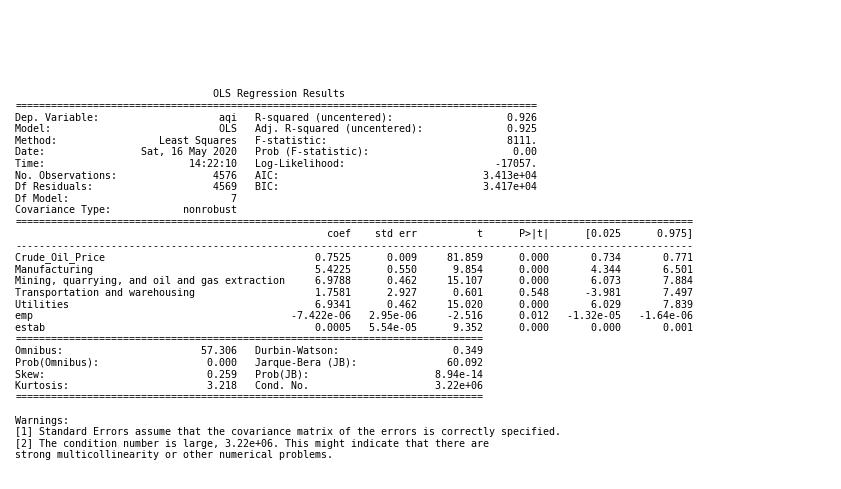

In [76]:
model = sm.OLS(y,x).fit()
predictions = model.predict(x)
plt.rc('figure', figsize=(12, 7))
plt.text(0.01, 0.05, str(model.summary()), {'fontsize': 12}, fontproperties = 'monospace')
plt.axis('off')
plt.tight_layout()
plt.show()

# Exporting AQI, Census, Oil Data to CSV to use in Tableau

In [79]:
aqi_census_oil.to_csv('../data/aqi_census_oil1.csv')


In [42]:
y1 = pm25_census_oil['sample']
x1 = pm25_census_oil[['Crude_Oil_Price','Manufacturing','Mining, quarrying, and oil and gas extraction','Transportation and warehousing','Utilities']]

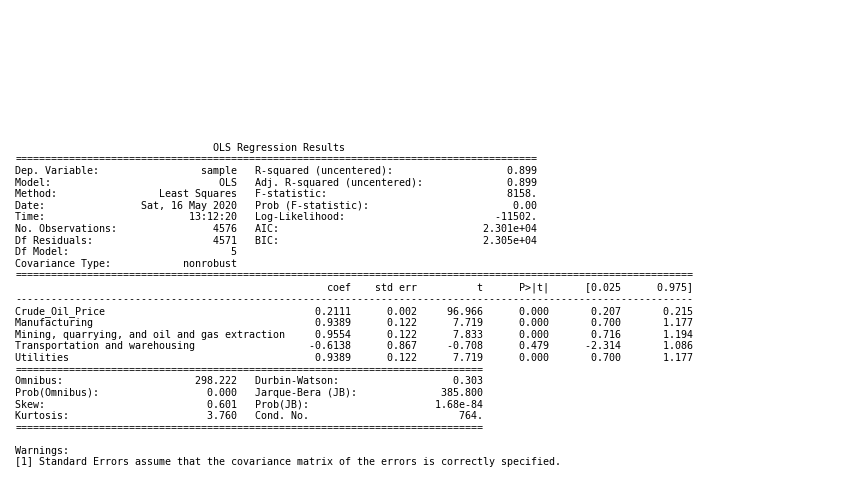

In [43]:
model = sm.OLS(y1,x1).fit()
predictions = model.predict(x1)
plt.rc('figure', figsize=(12, 7))
plt.text(0.01, 0.05, str(model.summary()), {'fontsize': 12}, fontproperties = 'monospace')
plt.axis('off')
plt.tight_layout()
plt.show()